# Clustering Crypto

In [25]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


### Fetching Cryptocurrency Data

In [26]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"
# data = requests.get(url).json()
# list(data.keys())

In [27]:
# Create a DataFrame 
# data_df = pd.DataFrame(data["Data"]).T
# data_df.head()

In [28]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")
file_path = Path("data/crypto_data.csv")

# Create a DataFrame
crypto_df = pd.read_csv(file_path,index_col=0)
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [29]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df = crypto_df.loc[:,['CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply']]
crypto_df.head(10)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


In [30]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df["IsTrading"]==True]
crypto_df.head()


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [31]:
# Keep only cryptocurrencies with a working algorithm
crypto_df = crypto_df[crypto_df['Algorithm']!="N/A"]
crypto_df.head()


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [32]:
# Remove the 'IsTrading' column
crypto_df.drop(columns=["IsTrading"], inplace=True)
crypto_df.head()


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,PoW,NaN,611000
808,808,SHA-256,PoW/PoS,0.000000e+00,0


In [33]:
# Remove rows with at least 1 null value
crypto_df = crypto_df.dropna()
crypto_df.isnull().sum()


CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

In [34]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df["TotalCoinsMined"]>0]
crypto_df.head()


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0


In [35]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df!='N/A']
crypto_df.dropna(inplace=True)
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0


In [36]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df 
coins_name = crypto_df["CoinName"]
coins_name.head()


42        42 Coin
404       404Coin
1337    EliteCoin
BTC       Bitcoin
ETH      Ethereum
Name: CoinName, dtype: object

In [37]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(columns=["CoinName"], inplace=True)
crypto_df.head()


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0


In [38]:
# Create dummy variables for text features
X_encoded = pd.get_dummies(crypto_df, columns=['Algorithm','ProofType'])
X_encoded.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Standardize data
X_scaled = StandardScaler().fit_transform(X_encoded)
print(X_scaled[0:2])


[[-0.11710817 -0.1528703  -0.0433963  -0.0433963  -0.0433963  -0.06142951
  -0.07530656 -0.0433963  -0.06142951 -0.06142951 -0.0433963  -0.0433963
  -0.19245009 -0.06142951 -0.09740465 -0.0433963  -0.11547005 -0.07530656
  -0.0433963  -0.0433963  -0.15191091 -0.0433963  -0.13118084 -0.0433963
  -0.0433963  -0.08703883 -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.06142951 -0.0433963  -0.08703883 -0.08703883 -0.08703883 -0.0433963
  -0.13118084 -0.13840913 -0.13840913 -0.0433963  -0.06142951 -0.0433963
  -0.07530656 -0.18168574 -0.0433963  -0.0433963  -0.0433963  -0.07530656
  -0.15826614 -0.31491833 -0.0433963  -0.08703883 -0.07530656 -0.06142951
   1.38675049 -0.0433963  -0.0433963  -0.06142951 -0.0433963  -0.0433963
  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.39879994 -0.0433963  -0.18168574 -0.0433963  -0.08703883 -0.08703883
  -0.10680283 -0.0433963  -0.13118084 -0.0433963  -0.0433963  -0.0433963
  -0.0433963  -0.07530656 -0.43911856 -0.04339

### Reducing Dimensions Using PCA

In [40]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(X_scaled)

In [41]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(
    data = crypto_pca, 
    columns = ["PC 1", "PC 2","PC 3"],
    index = crypto_df.index
)
pcs_df.head()

,PC 1,PC 2,PC 3
42,-0.333669,1.006055,-0.566198
404,-0.317023,1.006163,-0.566305
1337,2.312328,1.594746,-0.617675
BTC,-0.138692,-1.330426,0.162366
ETH,-0.147766,-2.034623,0.379816


### Clustering Crytocurrencies Using K-Means

#### Finding the Best Value for `k` Using the Elbow Curve

In [42]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)


# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")


C:\Users\yuanyuan\anaconda3\envs\alpacaenv\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [43]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
pcs_df["Class"] = model.labels_

clustered_df = pd.concat([coins_name,crypto_df,pcs_df],axis=1)
clustered_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,Class
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42,-0.333669,1.006055,-0.566198,0
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.317023,1.006163,-0.566305,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359,2.312328,1.594746,-0.617675,0
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000,-0.138692,-1.330426,0.162366,1
ETH,Ethereum,Ethash,PoW,1.076842e+08,0,-0.147766,-2.034623,0.379816,1


### Visualizing Results

#### 3D-Scatter with Clusters

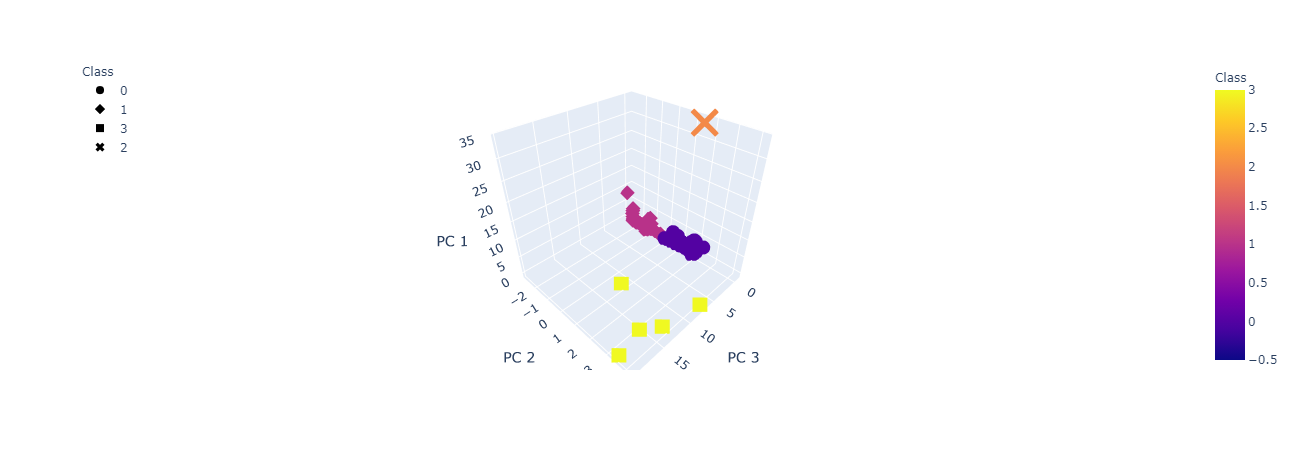

In [44]:
#Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 3",
    y="PC 2",
    z="PC 1",
    color="Class",
    symbol="Class",
    width=800,
    hover_name="CoinName",
    hover_data=["Algorithm"]
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [45]:
# Table with tradable cryptos
tradable_cryptos = clustered_df.hvplot.table(columns=["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "Class"])
tradable_cryptos

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [46]:
# Print the total number of tradable cryptocurrencies
print(f"The total number of tradable cryptocurrencies is {len(clustered_df.index)}")

The total number of tradable cryptocurrencies is 532


#### Scatter Plot with Tradable Cryptocurrencies

In [47]:
# Scale data to create the scatter plot
clustered_df["TotalCoinSupply"] = clustered_df["TotalCoinSupply"].astype(float)/100000000
clustered_df["TotalCoinsMined"] = clustered_df["TotalCoinsMined"].astype(float)/100000000

In [48]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot.scatter(
    x="TotalCoinsMined", 
    y="TotalCoinSupply", 
    by="Class",
    hover_cols=["CoinName"]
)

:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)